In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import logging

In [7]:
# ---------- CONFIG ----------
BASE = Path(r"E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data")

PHASE3_OUTPUT = BASE / "wsl_actions_with_decision_efficiency_FULL.csv"   # From Phase 3
PHASE1_DATA = BASE / "wsl_events_with_gamestate.csv"                     # From Phase 1
OUTPUT_GAMESTATE = BASE / "wsl_actions_with_gamestate_efficiency.csv"
TEAM_OUTPUT = BASE / "team_gamestate_efficiency.csv"
PLAYER_OUTPUT = BASE / "player_gamestate_efficiency.csv"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
log = logging.getLogger("Phase4")

log.info("🎯 Starting Phase 4: Game State Integration")
start_time = time.time()

2025-08-27 17:50:53,615 - INFO - 🎯 Starting Phase 4: Game State Integration


In [8]:
# ---------- STEP 1: Load Phase 3 Data ----------
log.info("📂 Loading Phase 3 decision efficiency data...")
decision_data = pd.read_csv(PHASE3_OUTPUT, low_memory=False)
log.info(f"✅ Loaded {len(decision_data):,} actions ({decision_data.shape[1]} columns)")

log.info("   Checking decision efficiency stats...")
log.info(f"   Range: {decision_data['realistic_decision_efficiency_ratio'].min():.2f} "
         f"to {decision_data['realistic_decision_efficiency_ratio'].max():.2f}")
log.info(f"   Mean: {decision_data['realistic_decision_efficiency_ratio'].mean():.3f}")

2025-08-27 17:50:56,041 - INFO - 📂 Loading Phase 3 decision efficiency data...
2025-08-27 17:50:58,544 - INFO - ✅ Loaded 473,805 actions (25 columns)
2025-08-27 17:50:58,545 - INFO -    Checking decision efficiency stats...
2025-08-27 17:50:58,552 - INFO -    Range: -60654.18 to 176085.88
2025-08-27 17:50:58,556 - INFO -    Mean: 51.441


In [9]:
# ---------- STEP 2: Load Game State Data ----------
log.info("📂 Loading Phase 1 game state data...")
gamestate_data = pd.read_csv(PHASE1_DATA, low_memory=False)
log.info(f"✅ Loaded {len(gamestate_data):,} events ({gamestate_data.shape[1]} columns)")

# Select only essential columns
gamestate_cols = ['id', 'match_id', 'minute', 'second', 'possession', 'game_state']
gamestate_data = gamestate_data[gamestate_cols].copy()

2025-08-27 17:51:49,160 - INFO - 📂 Loading Phase 1 game state data...
2025-08-27 17:51:54,849 - INFO - ✅ Loaded 1,095,921 events (16 columns)


In [10]:
# ---------- STEP 3: Merge Decision Data with Game State ----------
log.info("🔗 Merging decision efficiency with game state...")
merged_df = decision_data.merge(
    gamestate_data, 
    on=['id', 'match_id', 'minute', 'second', 'possession'],
    how='left'
)

log.info(f"✅ Merged dataset: {len(merged_df):,} rows")
log.info(f"   Missing game states: {merged_df['game_state'].isna().sum():,}")
log.info(f"   Available game states: {merged_df['game_state'].notna().sum():,}")

2025-08-27 17:52:02,577 - INFO - 🔗 Merging decision efficiency with game state...
2025-08-27 17:52:03,627 - INFO - ✅ Merged dataset: 473,805 rows
2025-08-27 17:52:03,645 - INFO -    Missing game states: 0
2025-08-27 17:52:03,665 - INFO -    Available game states: 473,805


In [11]:
# ---------- STEP 4: Cleaning & Preparation ----------
log.info("🧹 Cleaning and preparing data...")

# Drop rows with missing game state
initial_count = len(merged_df)
merged_df = merged_df.dropna(subset=['game_state'])
log.info(f"   Removed {initial_count - len(merged_df):,} rows with missing game state")

# Map categories
state_map = {'winning': 'Winning', 'drawing': 'Drawing', 'losing': 'Losing'}
merged_df['game_state_category'] = merged_df['game_state'].map(state_map)

# Remove extreme efficiency values for robustness
cleaned_df = merged_df[
    (merged_df['realistic_decision_efficiency_ratio'] > -10) & 
    (merged_df['realistic_decision_efficiency_ratio'] < 10)
]
log.info(f"   Removed {len(merged_df) - len(cleaned_df):,} extreme efficiency rows")
log.info(f"   Final dataset: {len(cleaned_df):,} actions")

# Save cleaned dataset
cleaned_df.to_csv(OUTPUT_GAMESTATE, index=False)
log.info(f"💾 Saved merged dataset with game state to {OUTPUT_GAMESTATE}")

2025-08-27 17:52:19,073 - INFO - 🧹 Cleaning and preparing data...
2025-08-27 17:52:19,227 - INFO -    Removed 0 rows with missing game state
2025-08-27 17:52:19,350 - INFO -    Removed 16,153 extreme efficiency rows
2025-08-27 17:52:19,351 - INFO -    Final dataset: 457,652 actions
2025-08-27 17:52:29,891 - INFO - 💾 Saved merged dataset with game state to E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\wsl_actions_with_gamestate_efficiency.csv


In [12]:
# ---------- STEP 5: Analysis by Game State ----------
log.info("📈 Analyzing decision efficiency by game state...")

efficiency_by_state = cleaned_df.groupby('game_state_category').agg(
    mean_efficiency=('realistic_decision_efficiency_ratio','mean'),
    median_efficiency=('realistic_decision_efficiency_ratio','median'),
    std_efficiency=('realistic_decision_efficiency_ratio','std'),
    action_count=('id','count'),
    avg_xT=('xT_added','mean')
).round(3)

log.info("📊 Decision Efficiency by Game State:")
log.info(f"\n{efficiency_by_state}")

2025-08-27 17:52:47,531 - INFO - 📈 Analyzing decision efficiency by game state...
2025-08-27 17:52:47,623 - INFO - 📊 Decision Efficiency by Game State:
2025-08-27 17:52:47,635 - INFO - 
                     mean_efficiency  median_efficiency  std_efficiency  \
game_state_category                                                       
Drawing                        0.294                0.0           1.659   
Losing                         0.294                0.0           1.677   
Winning                        0.296                0.0           1.611   

                     action_count  avg_xT  
game_state_category                        
Drawing                    186653  -0.002  
Losing                     114725  -0.002  
Winning                    156274  -0.002  


In [13]:
# ---------- STEP 6: Team-Level Analysis ----------
log.info("🏆 Team-level analysis by game state")

team_eff = cleaned_df.groupby(['team','game_state_category']).agg(
    mean_efficiency=('realistic_decision_efficiency_ratio','mean'),
    avg_xT=('xT_added','mean'),
    action_count=('id','count')
).round(3).reset_index()

team_pivot = team_eff.pivot(index='team', columns='game_state_category', values='mean_efficiency')
complete_teams = team_pivot.dropna(how='any')

complete_teams.to_csv(TEAM_OUTPUT, index=True)
log.info(f"💾 Saved team efficiency to {TEAM_OUTPUT}")

2025-08-27 17:53:01,566 - INFO - 🏆 Team-level analysis by game state
2025-08-27 17:53:01,698 - INFO - 💾 Saved team efficiency to E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\team_gamestate_efficiency.csv


In [14]:
# ---------- STEP 7: Player-Level Analysis ----------
log.info("👤 Player-level analysis by game state")

player_eff = cleaned_df.groupby(['player','game_state_category']).agg(
    mean_efficiency=('realistic_decision_efficiency_ratio','mean'),
    avg_xT=('xT_added','mean'),
    action_count=('id','count')
).round(3).reset_index()

player_pivot = player_eff.pivot(index='player', columns='game_state_category', values='mean_efficiency')

# Add pressure performance metric
player_pivot['pressure_performance'] = player_pivot.get('Losing', np.nan) - player_pivot.get('Winning', np.nan)
player_pivot['total_actions'] = cleaned_df.groupby('player')['id'].count()

qualified_players = player_pivot[(player_pivot['total_actions'] > 100)].dropna()

qualified_players.to_csv(PLAYER_OUTPUT, index=True)
log.info(f"💾 Saved player efficiency to {PLAYER_OUTPUT}")

2025-08-27 17:53:15,656 - INFO - 👤 Player-level analysis by game state
2025-08-27 17:53:15,921 - INFO - 💾 Saved player efficiency to E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data\player_gamestate_efficiency.csv


In [15]:
# ---------- STEP 8: Summary ----------
log.info("\n🎉 PHASE 4 COMPLETE!")
log.info("=======================================")
log.info(f"📊 Dataset: {len(cleaned_df):,} actions with game state")
log.info(f"🏆 Teams analyzed: {len(complete_teams)}")
log.info(f"👤 Players analyzed: {len(qualified_players)}")
log.info(f"🎮 Game states: Winning, Drawing, Losing")
log.info(f"\nOverall efficiency:\n{efficiency_by_state}")

log.info(f"Total runtime: {time.time()-start_time:.1f}s")

2025-08-27 17:53:24,811 - INFO - 
🎉 PHASE 4 COMPLETE!
2025-08-27 17:53:24,812 - INFO - =======================================
2025-08-27 17:53:24,815 - INFO - 📊 Dataset: 457,652 actions with game state
2025-08-27 17:53:24,816 - INFO - 🏆 Teams analyzed: 14
2025-08-27 17:53:24,818 - INFO - 👤 Players analyzed: 330
2025-08-27 17:53:24,819 - INFO - 🎮 Game states: Winning, Drawing, Losing
2025-08-27 17:53:24,824 - INFO - 
Overall efficiency:
                     mean_efficiency  median_efficiency  std_efficiency  \
game_state_category                                                       
Drawing                        0.294                0.0           1.659   
Losing                         0.294                0.0           1.677   
Winning                        0.296                0.0           1.611   

                     action_count  avg_xT  
game_state_category                        
Drawing                    186653  -0.002  
Losing                     114725  -0.002  
Winning

In [16]:
import pandas as pd
from pathlib import Path

BASE = Path(r"E:\MSc Big Data Analytics in Football\WSL project\Statsbombpy data")

merged = pd.read_csv(BASE / "wsl_actions_with_gamestate_efficiency.csv")

print("Shape:", merged.shape)
print("Columns:", list(merged.columns)[:10])
print("Unique teams:", merged['team'].nunique())
print("Unique players:", merged['player'].nunique())
print("Game states:", merged['game_state_category'].unique())

Shape: (457652, 27)
Columns: ['id', 'match_id', 'minute', 'second', 'type', 'possession', 'possession_team', 'team', 'player', 'location_x']
Unique teams: 14
Unique players: 408
Game states: ['Drawing' 'Winning' 'Losing']


In [17]:
print(merged['game_state_category'].value_counts(normalize=True).round(3))

game_state_category
Drawing    0.408
Winning    0.341
Losing     0.251
Name: proportion, dtype: float64


In [18]:
print("Delta range:", merged["realistic_decision_efficiency_delta"].min(), 
                   merged["realistic_decision_efficiency_delta"].max())

print("Ratio range:", merged["realistic_decision_efficiency_ratio"].min(), 
                   merged["realistic_decision_efficiency_ratio"].max())

Delta range: -0.2986732970204049 0.2986732970204049
Ratio range: -9.992825876488167 9.998321425921745


In [19]:
player_check = merged.groupby("player").agg(
    n_actions=("id","count"),
    avg_eff=("realistic_decision_efficiency_delta","mean")
).sort_values("n_actions", ascending=False).head(10)
print(player_check)

                               n_actions   avg_eff
player                                            
Leah Williamson                     6647 -0.016791
Keira Walsh                         6347 -0.030091
Stephanie Houghton                  5975 -0.017804
Millie Bright                       5971 -0.020557
Magdalena Lilly Eriksson            5829 -0.012374
Katie McCabe                        5359 -0.017131
Caroline Weir                       5286 -0.031523
So-Yun Ji                           5144 -0.032634
Jonna Ann-Charlotte Andersson       4688 -0.011177
Lia Wälti                           4490 -0.023275


                         team  Drawing  Losing  Winning
0                 Arsenal WFC    0.292   0.297    0.284
1                 Aston Villa    0.325   0.296    0.406
2         Birmingham City WFC    0.298   0.282    0.298
3  Brighton & Hove Albion WFC    0.298   0.285    0.307
4            Bristol City WFC    0.322   0.276    0.329


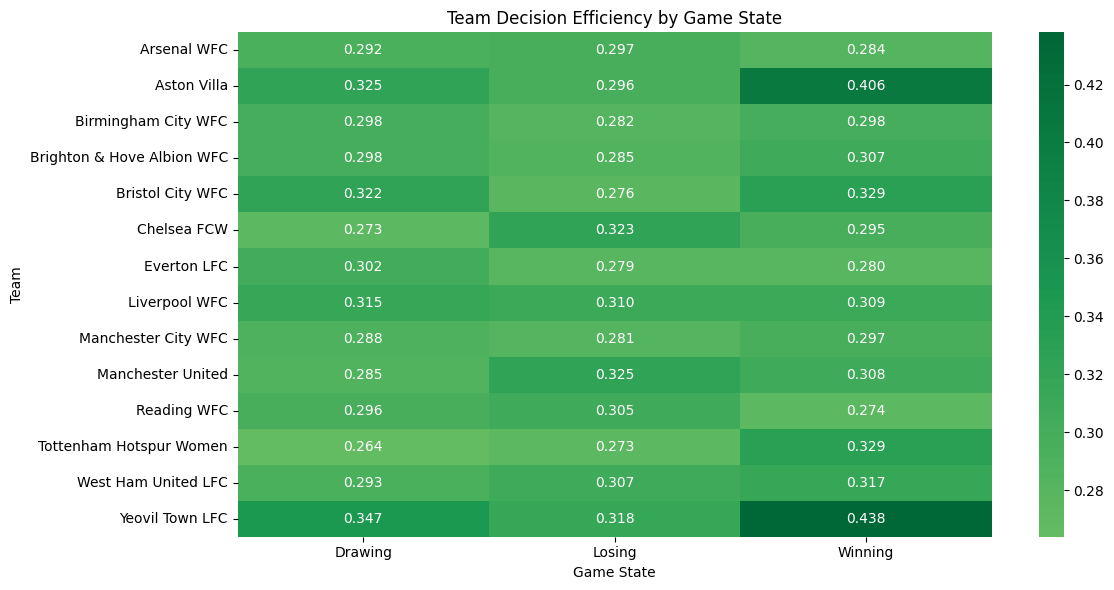

In [24]:
team = pd.read_csv(BASE / "team_gamestate_efficiency.csv")
print(team.head())

# Compare efficiency across states
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(
    team.set_index("team"),  # Use team name as index
    annot=True,
    cmap="RdYlGn",
    center=0,
    fmt=".3f"
)
plt.title("Team Decision Efficiency by Game State")
plt.ylabel("Team")
plt.xlabel("Game State")
plt.tight_layout()
plt.show()

In [21]:
players = pd.read_csv(BASE / "player_gamestate_efficiency.csv")

# Sort by performance under pressure
top_pressure = players.sort_values("pressure_performance", ascending=False).head(10)
print("Top pressure players:\n", top_pressure[["player","pressure_performance"]])

top_choke = players.sort_values("pressure_performance").head(10)
print("Top choke players:\n", top_choke[["player","pressure_performance"]])

Top pressure players:
                            player  pressure_performance
48               Charlotte Buxton                 0.818
212             Lisa-Marie Utland                 0.748
5                  Adelina Engman                 0.727
247               Melanie Leupolz                 0.641
224  Lydia Grace Yilkari Williams                 0.640
209                   Lily Simkin                 0.593
180                  Katrine Veje                 0.545
114                   Ga-Eul Jeon                 0.543
26          Anne-Marie Heatherson                 0.518
23              Ann-Katrin Berger                 0.518
Top choke players:
                     player  pressure_performance
72       Denise O'Sullivan                -1.071
131         Hannah Hampton                -1.058
215           Lotta Ökvist                -0.961
25             Anna Patten                -0.878
286  Rebecca Leigh Spencer                -0.779
13         Alexandra Riley                -0.61

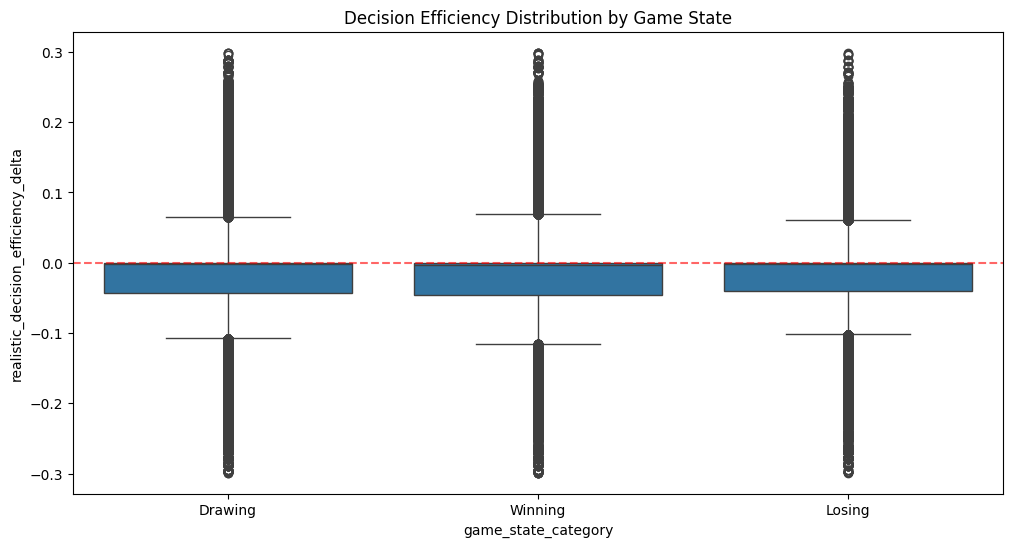

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=merged, x="game_state_category", y="realistic_decision_efficiency_delta")
plt.axhline(0, ls="--", color="red", alpha=0.6)
plt.title("Decision Efficiency Distribution by Game State")
plt.show()